# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number

In [ ]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx=xx.T
yy = Energies

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xs_train[:,0] = (x_train[:,0] - np.average(x_train[:,0])) / np.average(x_train[:,0])
xs_test[:,0] = (x_test[:,0] - np.average(x_test[:,0])) / np.average(x_test[:,0])
xs_train[:,1] = (x_train[:,1] - np.average(x_train[:,1])) / np.average(x_train[:,1])
xs_test[:,1] = (x_test[:,1] - np.average(x_test[:,1])) / np.average(x_test[:,1])

print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(xs_train.shape, xs_train.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}\n'.format(y_train.shape, y_train.dtype))
print('Test Features:\n   Shape: {}\n   Type: {}\n'.format(xs_test.shape, xs_test.dtype))
print('Test Targets:\n   Shape: {}\n   Type: {}\n'.format(y_test.shape, y_test.dtype))

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss=tf.keras.losses.MeanSquaredError(),metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,y_train,epochs=5000, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, y_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Features:
   Shape: (1997, 2)
   Type: float64

Training Targets:
   Shape: (1997,)
   Type: float64

Test Features:
   Shape: (500, 2)
   Type: float64

Test Targets:
   Shape: (500,)
   Type: float64

Train on 1597 samples, validate on 400 samples
Epoch 1/5000
1597/1597 [==============================] - 2s 2ms/sample - loss: 61.9673 - R2: -349.5199 - val_loss: 58.5748 - val_R2: -303.8964
Epoch 2/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 50.1203 - R2: -273.6432 - val_loss: 38.7200 - val_R2: -214.1431
Epoch 3/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 22.6624 - R2: -120.1408 - val_loss: 9.7923 - val_R2: -52.1532
Epoch 4/5000
1597/1597 [==============================] - 0s 296us/sample - loss: 6.4928 - R2: -34.1163 - val_loss: 5.0284 - val_R2: -21.7878
Epoch 5/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 4.2718 - R2: -17.8579 - val_loss: 3.4792 - val_R2: -14.1756
Epoch 6/5000
1597/1597 

Epoch 58/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.1428 - R2: 0.6897 - val_loss: 0.1102 - val_R2: 0.7909
Epoch 59/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.1412 - R2: 0.6920 - val_loss: 0.1096 - val_R2: 0.7749
Epoch 60/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.1429 - R2: 0.6651 - val_loss: 0.1102 - val_R2: 0.7642
Epoch 61/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.1412 - R2: 0.6917 - val_loss: 0.1045 - val_R2: 0.7807
Epoch 62/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.1335 - R2: 0.7161 - val_loss: 0.1053 - val_R2: 0.6614
Epoch 63/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.1409 - R2: 0.6673 - val_loss: 0.1055 - val_R2: 0.7560
Epoch 64/5000
1597/1597 [==============================] - 0s 268us/sample - loss: 0.1386 - R2: 0.6728 - val_loss: 0.1020 - val_R2: 0.7347
Epoch 65/5000
1597/1597 [==

Epoch 117/5000
1597/1597 [==============================] - 0s 280us/sample - loss: 0.1067 - R2: 0.7667 - val_loss: 0.0634 - val_R2: 0.8893
Epoch 118/5000
1597/1597 [==============================] - 0s 273us/sample - loss: 0.1051 - R2: 0.7702 - val_loss: 0.0647 - val_R2: 0.8746
Epoch 119/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.1094 - R2: 0.7751 - val_loss: 0.0687 - val_R2: 0.8563
Epoch 120/5000
1597/1597 [==============================] - 0s 277us/sample - loss: 0.1063 - R2: 0.7610 - val_loss: 0.0626 - val_R2: 0.8643
Epoch 121/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.1091 - R2: 0.7349 - val_loss: 0.0611 - val_R2: 0.8500
Epoch 122/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.1083 - R2: 0.7169 - val_loss: 0.0613 - val_R2: 0.8087
Epoch 123/5000
1597/1597 [==============================] - 0s 297us/sample - loss: 0.1102 - R2: 0.7610 - val_loss: 0.0616 - val_R2: 0.8442
Epoch 124/5000
1597/

1597/1597 [==============================] - 0s 294us/sample - loss: 0.0951 - R2: 0.7588 - val_loss: 0.0487 - val_R2: 0.8594
Epoch 176/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 0.1005 - R2: 0.7399 - val_loss: 0.0548 - val_R2: 0.8056
Epoch 177/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0996 - R2: 0.7704 - val_loss: 0.0551 - val_R2: 0.8288
Epoch 178/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0963 - R2: 0.7659 - val_loss: 0.0461 - val_R2: 0.8970
Epoch 179/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0929 - R2: 0.7770 - val_loss: 0.0466 - val_R2: 0.8576
Epoch 180/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0979 - R2: 0.7464 - val_loss: 0.0591 - val_R2: 0.7920
Epoch 181/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0963 - R2: 0.7680 - val_loss: 0.0519 - val_R2: 0.9046
Epoch 182/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 285us/sample - loss: 0.0956 - R2: 0.7867 - val_loss: 0.0468 - val_R2: 0.8764
Epoch 234/5000
1597/1597 [==============================] - 0s 282us/sample - loss: 0.0939 - R2: 0.7835 - val_loss: 0.0426 - val_R2: 0.9006
Epoch 235/5000
1597/1597 [==============================] - 0s 298us/sample - loss: 0.0903 - R2: 0.7976 - val_loss: 0.0418 - val_R2: 0.8928
Epoch 236/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0911 - R2: 0.7535 - val_loss: 0.0408 - val_R2: 0.8953
Epoch 237/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0923 - R2: 0.7870 - val_loss: 0.0418 - val_R2: 0.8823
Epoch 238/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0879 - R2: 0.8146 - val_loss: 0.0384 - val_R2: 0.8855
Epoch 239/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0894 - R2: 0.7822 - val_loss: 0.0461 - val_R2: 0.9070
Epoch 240/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 305us/sample - loss: 0.0803 - R2: 0.8085 - val_loss: 0.0374 - val_R2: 0.9093
Epoch 292/5000
1597/1597 [==============================] - 0s 289us/sample - loss: 0.0839 - R2: 0.7948 - val_loss: 0.0396 - val_R2: 0.8891
Epoch 293/5000
1597/1597 [==============================] - 0s 299us/sample - loss: 0.0783 - R2: 0.8461 - val_loss: 0.0322 - val_R2: 0.9230
Epoch 294/5000
1597/1597 [==============================] - 0s 290us/sample - loss: 0.0829 - R2: 0.8347 - val_loss: 0.0404 - val_R2: 0.8784
Epoch 295/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0783 - R2: 0.7942 - val_loss: 0.0447 - val_R2: 0.8691
Epoch 296/5000
1597/1597 [==============================] - 0s 288us/sample - loss: 0.0789 - R2: 0.8374 - val_loss: 0.0354 - val_R2: 0.9099
Epoch 297/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0816 - R2: 0.8360 - val_loss: 0.0324 - val_R2: 0.9390
Epoch 298/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 300us/sample - loss: 0.0675 - R2: 0.8217 - val_loss: 0.0311 - val_R2: 0.9502
Epoch 350/5000
1597/1597 [==============================] - 0s 285us/sample - loss: 0.0654 - R2: 0.8830 - val_loss: 0.0267 - val_R2: 0.9337
Epoch 351/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0664 - R2: 0.8268 - val_loss: 0.0308 - val_R2: 0.9532
Epoch 352/5000
1597/1597 [==============================] - 0s 264us/sample - loss: 0.0662 - R2: 0.8774 - val_loss: 0.0313 - val_R2: 0.9546
Epoch 353/5000
1597/1597 [==============================] - 0s 274us/sample - loss: 0.0759 - R2: 0.8108 - val_loss: 0.0367 - val_R2: 0.9211
Epoch 354/5000
1597/1597 [==============================] - 0s 302us/sample - loss: 0.0691 - R2: 0.8544 - val_loss: 0.0250 - val_R2: 0.9463
Epoch 355/5000
1597/1597 [==============================] - 0s 286us/sample - loss: 0.0725 - R2: 0.8249 - val_loss: 0.0278 - val_R2: 0.9235
Epoch 356/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 293us/sample - loss: 0.0599 - R2: 0.9013 - val_loss: 0.0387 - val_R2: 0.9315
Epoch 408/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0602 - R2: 0.9054 - val_loss: 0.0224 - val_R2: 0.9460
Epoch 409/5000
1597/1597 [==============================] - 0s 265us/sample - loss: 0.0635 - R2: 0.8954 - val_loss: 0.0214 - val_R2: 0.9615
Epoch 410/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0571 - R2: 0.8967 - val_loss: 0.0298 - val_R2: 0.9048
Epoch 411/5000
1597/1597 [==============================] - 0s 291us/sample - loss: 0.0594 - R2: 0.8783 - val_loss: 0.0247 - val_R2: 0.9319
Epoch 412/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0566 - R2: 0.8912 - val_loss: 0.0335 - val_R2: 0.9347
Epoch 413/5000
1597/1597 [==============================] - 0s 304us/sample - loss: 0.0604 - R2: 0.8594 - val_loss: 0.0234 - val_R2: 0.9652
Epoch 414/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 286us/sample - loss: 0.0538 - R2: 0.8994 - val_loss: 0.0202 - val_R2: 0.9468
Epoch 466/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0508 - R2: 0.8663 - val_loss: 0.0190 - val_R2: 0.9621
Epoch 467/5000
1597/1597 [==============================] - 0s 294us/sample - loss: 0.0596 - R2: 0.8617 - val_loss: 0.0223 - val_R2: 0.9700
Epoch 468/5000
1597/1597 [==============================] - 0s 290us/sample - loss: 0.0493 - R2: 0.8871 - val_loss: 0.0248 - val_R2: 0.9282
Epoch 469/5000
1597/1597 [==============================] - 0s 271us/sample - loss: 0.0517 - R2: 0.8939 - val_loss: 0.0182 - val_R2: 0.9781
Epoch 470/5000
1597/1597 [==============================] - 0s 267us/sample - loss: 0.0516 - R2: 0.8929 - val_loss: 0.0174 - val_R2: 0.9674
Epoch 471/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0573 - R2: 0.8902 - val_loss: 0.0211 - val_R2: 0.9441
Epoch 472/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 293us/sample - loss: 0.0470 - R2: 0.9190 - val_loss: 0.0176 - val_R2: 0.9695
Epoch 524/5000
1597/1597 [==============================] - 0s 287us/sample - loss: 0.0467 - R2: 0.8939 - val_loss: 0.0195 - val_R2: 0.9565
Epoch 525/5000
1597/1597 [==============================] - 0s 280us/sample - loss: 0.0445 - R2: 0.9245 - val_loss: 0.0210 - val_R2: 0.9546
Epoch 526/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0438 - R2: 0.8938 - val_loss: 0.0191 - val_R2: 0.9657
Epoch 527/5000
1597/1597 [==============================] - 0s 276us/sample - loss: 0.0450 - R2: 0.8865 - val_loss: 0.0185 - val_R2: 0.9751
Epoch 528/5000
1597/1597 [==============================] - 0s 276us/sample - loss: 0.0400 - R2: 0.9181 - val_loss: 0.0436 - val_R2: 0.9366
Epoch 529/5000
1597/1597 [==============================] - 0s 283us/sample - loss: 0.0519 - R2: 0.8526 - val_loss: 0.0158 - val_R2: 0.9773
Epoch 530/5000
1597/1597 [=========

### Run a little more

If you want to run further epochs with the output model and a starting point, this cell should do it for you

Train on 1597 samples, validate on 400 samples
Epoch 1/20
1597/1597 [==============================] - 0s 295us/sample - loss: 0.3868 - R2: 0.2396 - val_loss: 0.3661 - val_R2: 0.2544
Epoch 2/20
1597/1597 [==============================] - 0s 282us/sample - loss: 0.3740 - R2: 0.1859 - val_loss: 0.3499 - val_R2: 0.3032
Epoch 3/20
1597/1597 [==============================] - 0s 269us/sample - loss: 0.3555 - R2: 0.3553 - val_loss: 0.3358 - val_R2: 0.4143
Epoch 4/20
1597/1597 [==============================] - 0s 261us/sample - loss: 0.3408 - R2: 0.3357 - val_loss: 0.3205 - val_R2: 0.4763
Epoch 5/20
1597/1597 [==============================] - 0s 282us/sample - loss: 0.3261 - R2: 0.4467 - val_loss: 0.3073 - val_R2: 0.5435
Epoch 6/20
1597/1597 [==============================] - 0s 292us/sample - loss: 0.3125 - R2: 0.4289 - val_loss: 0.2950 - val_R2: 0.4642
Epoch 7/20
1597/1597 [==============================] - 0s 296us/sample - loss: 0.3009 - R2: 0.4515 - val_loss: 0.2839 - val_R2: 0.5463
E

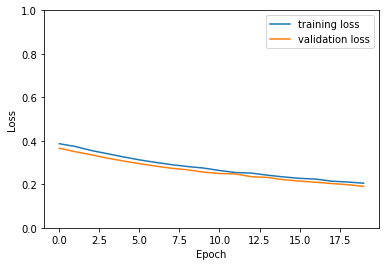

500/500 [==============================] - 0s 83us/sample - loss: 26753.3602 - R2: -158470.4844
Test Loss: 2.675e+04
Test R2: -1.585e+05


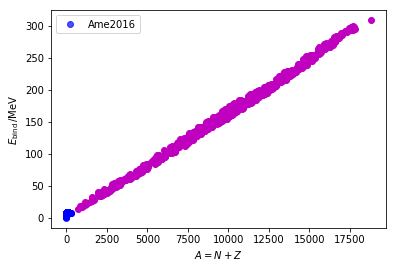

In [66]:
results=model.fit(xs_train,y_train,epochs=20, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, y_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [ ]:
print(model.predict([8,8]))